<div style="background-color:#00000">
    <img src="https://fundacionsadosky.org.ar/wp-content/uploads/2022/08/logo.png" />
</div>
<div style="background-color:#03030a; margin:20px 40%">
    <img src="https://www.rfindustrial.com/wp-content/uploads/2023/04/cropped-1080x1080_Mesa-de-trabajo-1.png" />
</div>
<div style="background-color:#00000;">
    <img src="https://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png" />
</div>

<p style="font-size: 30px">
    <strong>COPE - “Sistema inteligente de medición de nivel y control de velocidad de bombeo para pozos petrolíferos"</strong>
</p>

<p style="font-size: 20px">
    Objetivo del análisis: Realizar una validación inicial con un método simple de estimación de la velocidad del sonido.
</p>

24/03/2023

# Imports generales

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import struct
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, widgets
from scipy.signal import hilbert
from scipy.signal import butter, lfilter
from scipy import signal

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Configuración de rutas y accesos

In [2]:
DATA_PATH = '../data/raw/ecometrias/'

# Exploración de archivos para uno de los equipos

In [3]:
!tree ../data/raw/ecometrias/1

/Library/Developer/CommandLineTools/usr/bin/python3: No module named virtualfish
../data/raw/ecometrias/1
├── Cont
├── Program.json
├── ProgramCouter
├── _10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_02_15_24.json
│   ├── _Eco_02_20_53.json
│   ├── _Eco_02_34_25.json
│   ├── _Eco_02_42_17.json
│   ├── _Eco_02_48_12.json
│   └── _Eco_02_52_23.json
├── _10_23_19_19_57__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_19_19_57.json
│   ├── _Eco_19_20_51.json
│   └── _Eco_19_27_12.json
├── _10_23_19_51_27__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_19_51_27.json
├── _10_23_19_55_26__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_19_55_26.json
├── _10_24_00_17_50__Frec1(300)_IncF(150)_Nciclos(3)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_00_17_50.json
├── _10_24_00_20_09__Frec1(300)_IncF(150)_Nciclos(3)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_00_17_50.json
│   ├

# Definición de funciones útiles

In [4]:
def load_sample_file(sample_full_path):
    df = pd.read_json(sample_full_path, typ='series')
    
    final_values = []
    
    data_values = df.datos
    data_values = data_values.strip("[]").split(",")
    
    for value in data_values:
        # Convierte el valor hexadecimal a un entero sin signo de 32 bits
        value = int(value, 16) & 0xFFFFFFFF
        
        # Verifica si el bit más significativo es 1 para determinar si el valor está en complemento a uno
        if value & 0x80000000:
            # Si el bit más significativo es 1, convierte el valor a su complemento a dos
            value = -(0x100000000 - value)

        # Agrega el valor a la lista de enteros
        final_values.append(value)
    
    return df, final_values

# Determinación del ejemplo a utilizar

In [5]:
id_equipo = 1
path = '_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)'
file = '_Eco_02_15_24.json'
full_path = f'{DATA_PATH}/{id_equipo}/{path}/{file}'

df, output_signal = load_sample_file(full_path)
output_signal_norm = output_signal / np.max(np.abs(output_signal))

df

Id                                                         1
Frec1                                                    301
IncF                                                      40
Nciclos                                                    5
Aten                                                       0
SwIn                                                       1
Filter                                                     5
Down                                                      32
Dummy                                                      0
Nsamp                                                  16000
datos      [2CCBE557,4330934A,E726BD8A,E5DF3ED3,E48A54BC,...
dtype: object

## Visualización de señal de salida

In [6]:
def plot_signal_chunk(x_values, y_values, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    fig.subplots_adjust(bottom=0.2)
    ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
    ax.plot(x_values, y_values) # agregar datos a la gráfica
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.title(title)
    plt.show()

In [7]:
output_signal_sampling_freq = 930000 / df.Down
x_values = np.linspace(0, len(output_signal) / output_signal_sampling_freq, len(output_signal))

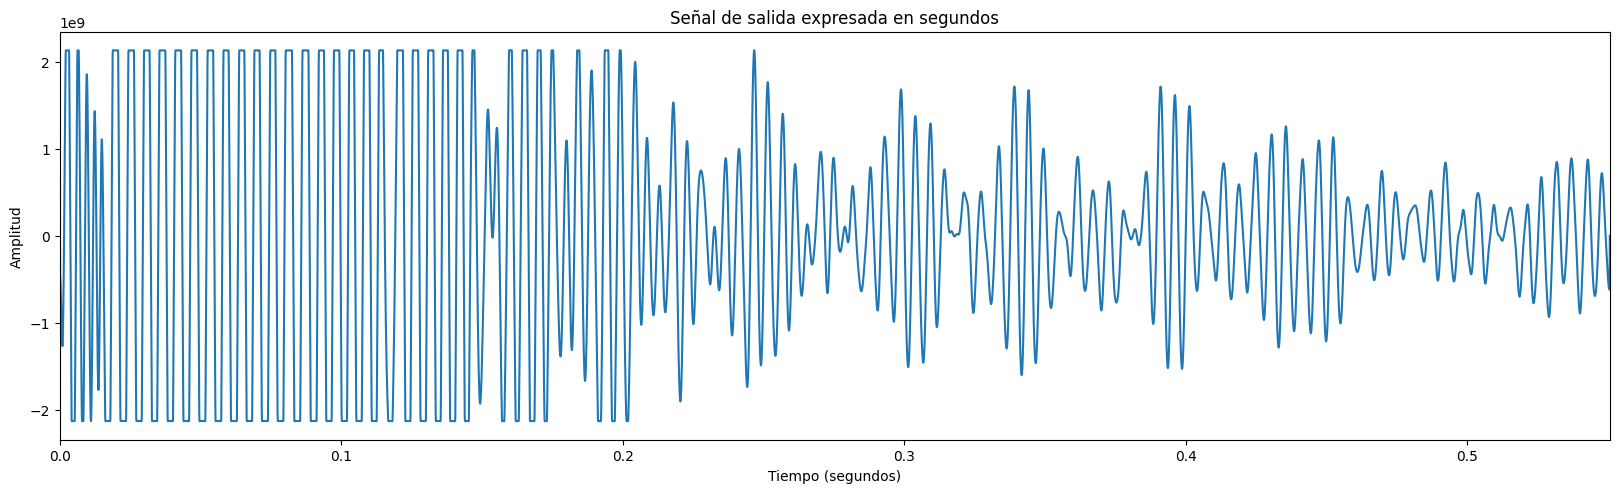

In [8]:
# Graficar señal
plot_signal_chunk(x_values, output_signal, 'Señal de salida expresada en segundos')

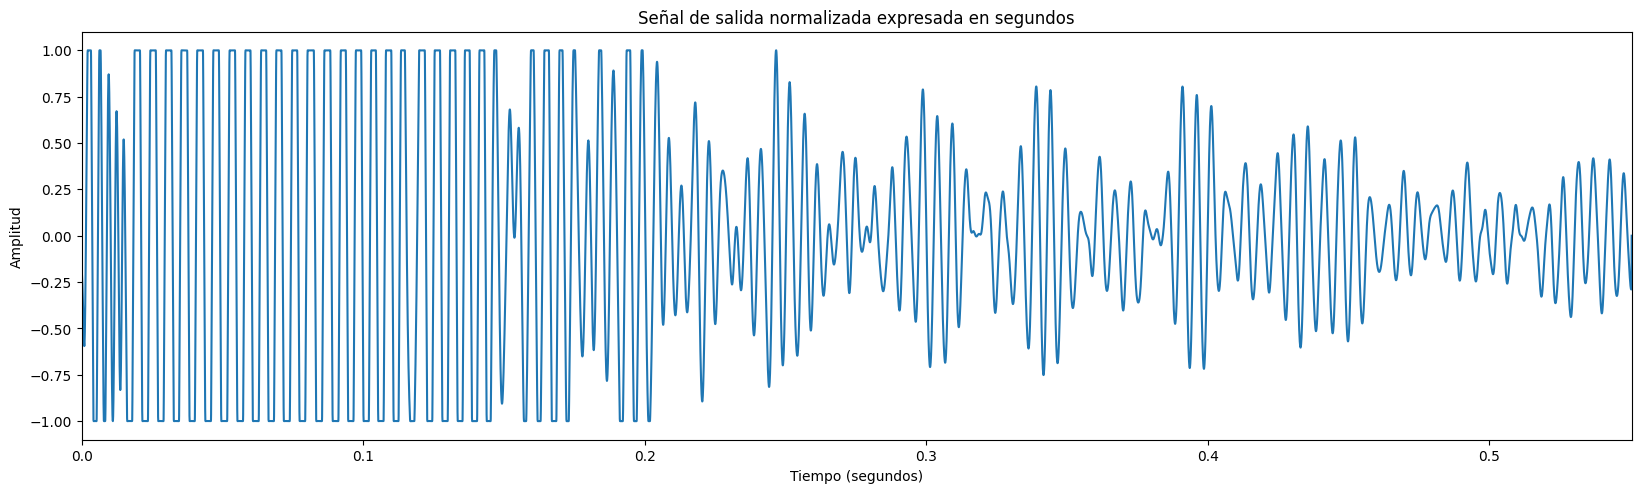

In [9]:
# Graficar señal
plot_signal_chunk(x_values, output_signal_norm, 'Señal de salida normalizada expresada en segundos')

## Acondionamiento de la señal

### Cálculo de la envolvente

In [10]:
output_signal_envelope = hilbert(output_signal_norm)
output_signal_envelope = np.abs(output_signal_envelope)

### FIltro pasa banda (Butter)

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=6):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
filter_center = 0.05 * output_signal_sampling_freq

output_signal_filtered = butter_bandpass_filter(output_signal_norm,
                                                filter_center - 50,
                                                filter_center + 50,
                                                output_signal_sampling_freq,
                                                5)

### Filtro pasa banda (Hamming)

In [13]:
f1, f2 = 100, 200
order = 100
fir_filter = signal.firwin(order + 1, [f1, f2], pass_zero=False, fs=output_signal_sampling_freq)
output_signal_filtered = lfilter(fir_filter, 1, output_signal_norm)

### Cálculo de la envolvente de la señal filtrada

In [14]:
filtered_signal_envelope = hilbert(output_signal_filtered)
filtered_signal_envelope = np.abs(filtered_signal_envelope)

### Suavizado de la envolvente de la señal filtrada

In [15]:
smooth_signal_envelope = np.convolve(filtered_signal_envelope, np.ones(250)/250, mode='same')

### Cálculo de picos y medidas

In [16]:
x_time_limit = 0.2
peaks_ix, peaks = signal.find_peaks(smooth_signal_envelope, height=0.25, distance=500)
peaks = peaks['peak_heights']
peaks_filter = peaks_ix > (x_time_limit * output_signal_sampling_freq)
peaks_ix = peaks_ix[peaks_filter] / output_signal_sampling_freq
peaks = peaks[peaks_filter]

peaks_average_diff = np.average(np.diff(peaks_ix))
estimated_speed = 9.6 / peaks_average_diff

# Grafico todas las señales de una vez

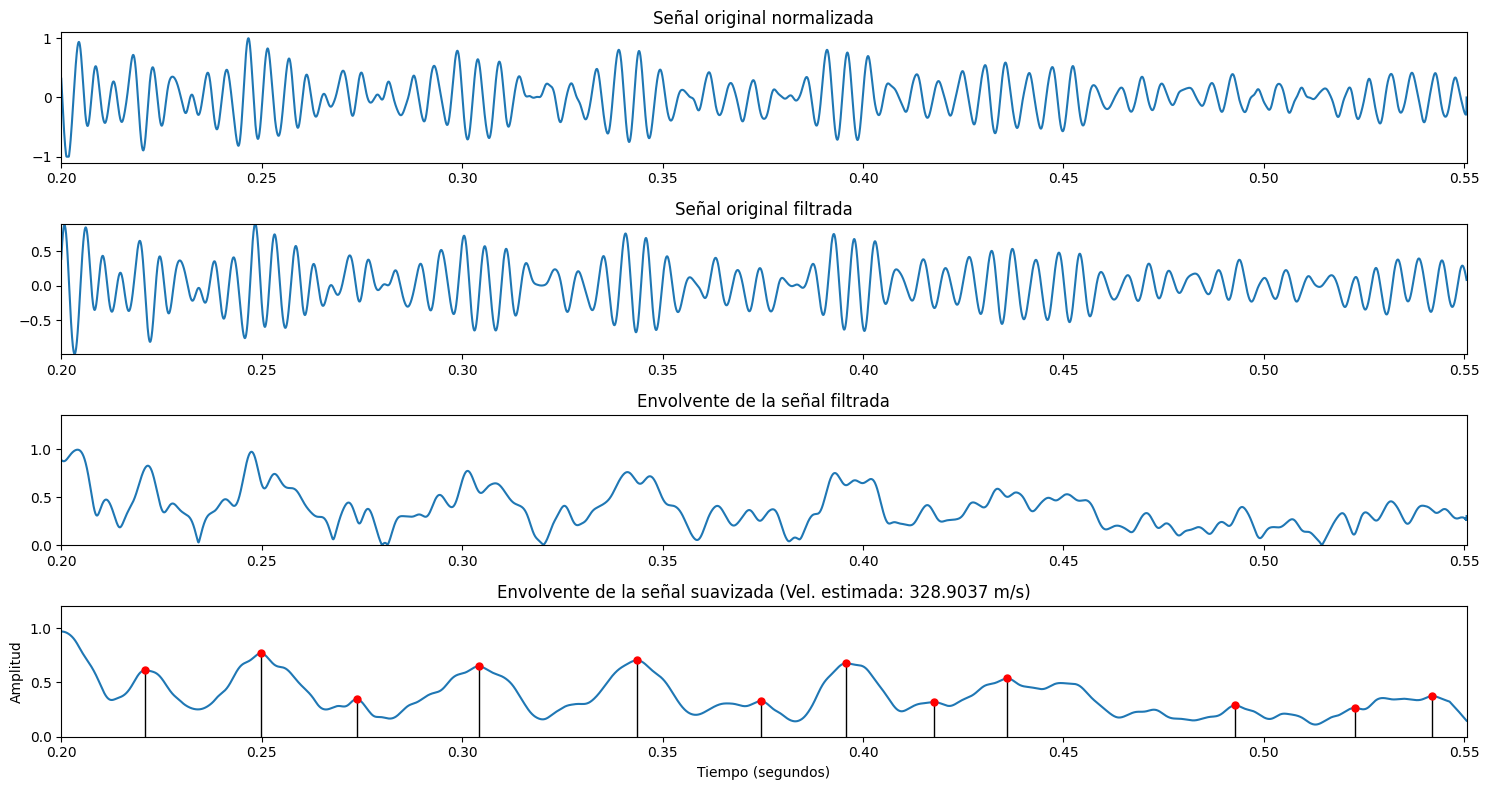

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(15, 8))


# Plot 1
axs[0].set_xlim([x_time_limit, x_values[-1]]) # establecer límites del eje x
axs[0].plot(x_values, output_signal_norm) # agregar datos a la gráfica
axs[0].set_title('Señal original normalizada')

# Plot 2
axs[1].set_xlim([x_time_limit, x_values[-1]]) # establecer límites del eje x
x_values_filter = x_values > x_time_limit
axs[1].set_ylim([min(output_signal_filtered[x_values_filter]), max(output_signal_filtered[x_values_filter])]) # establecer límites del eje x
axs[1].plot(x_values, output_signal_filtered) # agregar datos a la gráfica
axs[1].set_title('Señal original filtrada')

# Plot 3
axs[2].set_xlim([x_time_limit, x_values[-1]]) # establecer límites del eje x
axs[2].set_ylim([0, max(filtered_signal_envelope)])
axs[2].plot(x_values, filtered_signal_envelope) # agregar datos a la gráfica
axs[2].set_title('Envolvente de la señal filtrada')

# Plot 4
axs[3].set_xlim([x_time_limit, x_values[-1]]) # establecer límites del eje x
axs[3].set_ylim([0, max(smooth_signal_envelope)])
axs[3].plot(x_values, smooth_signal_envelope) # agregar datos a la gráfica
axs[3].set_title(f'Envolvente de la señal suavizada (Vel. estimada: {np.round(estimated_speed, 4)} m/s)')

for (peak_ix, peak) in zip(peaks_ix, peaks):
    axs[3].vlines(x=peak_ix,
                  ymin=0, ymax=peak,
                  color='black', lw=1)
    
    #axs[3].add_patch(plt.Circle((peak_ix, peak), color='red', radius=0.003, fill=False))
    axs[3].plot([peak_ix], [peak], 'r.', markersize=10.0)


plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
fig.tight_layout()
plt.show()

# Estimación de la velocidad promedio para distintos disparos

In [18]:
def complete_trial_estimation(path):
    reps = glob(path + '/*')
    
    estimated_speeds = []
    
    for rep in reps:
        # Get output signal.
        df, output_signal = load_sample_file(rep)
        
        # Normalize to avoid precision issues.
        output_signal_norm = output_signal / np.max(np.abs(output_signal))
        
        # Compute sampling frequency and get time ticks.
        output_signal_sampling_freq = 930000 / df.Down
        x_values = np.linspace(0, len(output_signal) / output_signal_sampling_freq, len(output_signal))
        
        # Filter signal.
        f1, f2 = 100, 200
        order = 100
        fir_filter = signal.firwin(order + 1, [f1, f2], pass_zero=False, fs=output_signal_sampling_freq)
        output_signal_filtered = lfilter(fir_filter, 1, output_signal_norm)
        
        # Compute envelope from filtered signal.
        filtered_signal_envelope = hilbert(output_signal_filtered)
        filtered_signal_envelope = np.abs(filtered_signal_envelope)
        
        # Smooth signal envelope.
        smooth_signal_envelope = np.convolve(filtered_signal_envelope, np.ones(250)/250, mode='same')
        
        # Find peaks.
        x_time_limit = 0.2
        peaks_ix, peaks = signal.find_peaks(smooth_signal_envelope, height=0.25, distance=500)
        peaks = peaks['peak_heights']
        peaks_filter = peaks_ix > (x_time_limit * output_signal_sampling_freq)
        peaks_ix = peaks_ix[peaks_filter] / output_signal_sampling_freq
        peaks = peaks[peaks_filter]

        peaks_average_diff = np.average(np.diff(peaks_ix))
        estimated_speed = 9.6 / peaks_average_diff
        estimated_speeds.append(estimated_speed)
    
    return estimated_speeds

In [19]:
results = complete_trial_estimation(f'{DATA_PATH}/{id_equipo}/{path}')
results

[329.5747422680412,
 363.4232121922626,
 334.49591280653954,
 332.79115159401425,
 368.72246696035245,
 328.90365448504974]

In [20]:
np.average(results)

342.9851900510433